In [1]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

In [2]:
FEAT_DIMS = 20
IMAGE_SHAPE = (128, 128, 3)
BATCH_SIZE = 64

In [4]:
IMAGE_SHAPE[0:2]

(128, 128)

In [42]:
from tensorflow import keras

train_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = IMAGE_SHAPE[0:2], 
                subset="training",
                validation_split=0.2,
                batch_size = BATCH_SIZE,
                seed = 1234,
                shuffle=True
                )

Found 39424 files belonging to 154 classes.
Using 31540 files for training.


In [43]:
test_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = IMAGE_SHAPE[0:2], 
                subset="validation",
                validation_split=0.2,
                batch_size = BATCH_SIZE,
                seed = 1234,
                shuffle=True
                )

Found 39424 files belonging to 154 classes.
Using 7884 files for validation.


In [172]:
train_dataset = train_dataset_.map(lambda x, y: (x/255., y))
#train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = test_dataset_.map(lambda x, y: (x/255., y))
#test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



In [173]:
a = next(iter(train_dataset))
b=a[0]
b.shape

TensorShape([64, 128, 128, 3])

In [174]:
n_classes = len(dataset.class_names)
n_samples = len(dataset) * BATCH_SIZE
n_batches = len(dataset)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  39424
n_batches =  616


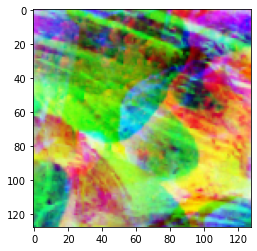

In [176]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

In [114]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [190]:
# Dataset hyperparameters
#unlabeled_dataset_size = 100000
#labeled_dataset_size = 5000
image_size = 128
image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
#batch_size = 525  # Corresponds to 200 steps per epoch
width = 128
temperature = 0.1
n_classes = 154

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

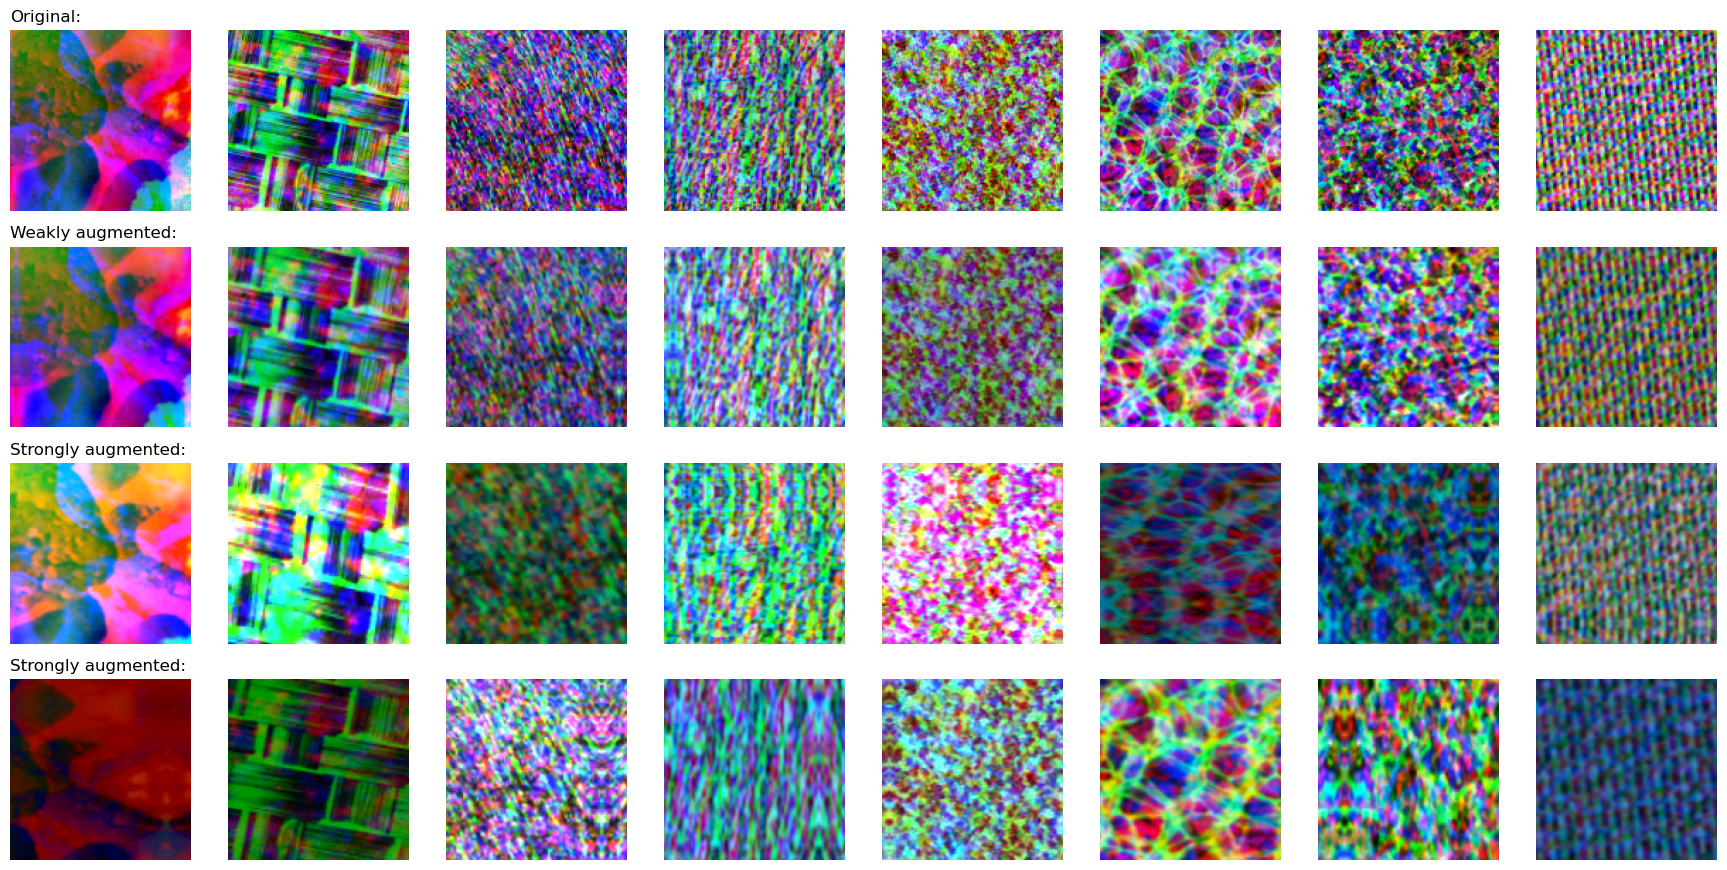

In [178]:

# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(image_size, image_size, image_channels)),
            #preprocessing.Rescaling(1 / 255),
            #preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            preprocessing.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    #images = next(iter(train_dataset))[0][0][:num_images]
        
    images = next(iter(train_dataset))[0][:num_images]
    
    #print(images.shape)
    #a=get_augmenter(**contrastive_augmentation)(images)
    
    #print(a.shape)
    
    
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    
    #print(augmented_images.shape)
    
    #return

    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image, vmin=0, vmax=1)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

In [121]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

# Supervised

In [191]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(n_classes),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)



In [192]:
images = next(iter(train_dataset))[0]
out = baseline_model.predict(images)
out.shape

(64, 154)

In [193]:
labels = next(iter(train_dataset))[1]

labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([ 48,  99,  74, 140, 112,  55,  53,  44,  45, 110,  15,  56,  81,
       104,  35, 112,  33, 104, 113,  21, 127,  95, 139,  19, 120, 148,
        79, 134, 138, 151, 113,  81, 122,  18,  25,   4,  95, 153,  88,
        83,  23, 138,  26, 106, 124,  88, 111, 147,   6,  86,  72,  61,
        46,  81,  40,   2,  52,  59,  63,  95, 149,  61,  45, 149],
      dtype=int32)>

In [194]:
baseline_model.layers[0].output

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'random_color_affine_127')>

In [195]:
baseline_model.layers[-1].output

<KerasTensor: shape=(None, 154) dtype=float32 (created by layer 'dense_131')>

In [197]:
baseline_history = baseline_model.fit(
    train_dataset, 
    epochs=5, 
    validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/5


ValueError: in user code:

    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py:552 call
        output = control_flow_util.smart_cond(training, random_translated_inputs,
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/control_flow_util.py:109 smart_cond
        return smart_module.smart_cond(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/smart_cond.py:54 smart_cond
        return true_fn()
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py:545 random_translated_inputs
        return transform(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py:678 transform
        return gen_image_ops.ImageProjectiveTransformV3(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/tf_export.py:404 wrapper
        return f(**kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_image_ops.py:2460 image_projective_transform_v3
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3557 _create_op_internal
        ret = Operation(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 4 but is rank 5 for '{{node baseline_model/sequential_127/random_translation_127/transform/ImageProjectiveTransformV3}} = ImageProjectiveTransformV3[dtype=DT_FLOAT, fill_mode="REFLECT", interpolation="BILINEAR"](IteratorGetNext, baseline_model/sequential_127/random_translation_127/translation_matrix/concat, baseline_model/sequential_127/random_translation_127/transform/strided_slice, baseline_model/sequential_127/random_translation_127/transform/fill_value)' with input shapes: [?,?,128,128,3], [?,8], [2], [].


# Contrastive learning

In [198]:

# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [keras.layers.InputLayer(input_shape=(width,)), layers.Dense(n_classes)], name="linear_probe"
        )

        #self.encoder.summary()
        #self.projection_head.summary()
        #self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        
        
        
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        #(unlabeled_images, _), (labeled_images, labels) = data

        
        #print("data[0].type=", type(data[0]))
        #print("data[1].type=", type(data[1]))
        
        
        # Both labeled and unlabeled images are used, without labels
        #images = tf.concat((unlabeled_images, labeled_images), axis=0)
        images,labels = data
        
        #images = tf.concat(images, axis=0)
        #images = tf.convert_to_tensor(images, dtype=tf.float32)
        
        #print("labels.type=",type(labels))
        #print("images.shape=", images.shape)
        #print(dir(labels))
        #print(type(images))
        
        #print("images=", images.get_shape())
        
        
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)
        
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            #print("contrastive_loss=", contrastive_loss)
            
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        
        
        labeled_images = images
        
        # Labels are only used in evalutation for an on-the-fly logistic regression
        #preprocessed_images = self.classification_augmenter(labeled_images)
        preprocessed_images = self.classification_augmenter(labeled_images)
        
        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            #print("features.shape=", features.shape)
            class_logits = self.linear_probe(features)
            #print("class_logits.shape=", class_logits.shape)
            probe_loss = self.probe_loss(labels, class_logits)
            #print("probe_loss=", probe_loss)
            
            
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        
        #print("=====")
        
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


In [199]:
pretraining_model = ContrastiveModel()

# Contrastive pretraining
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

num_epochs=1
pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

 91/493 [====>.........................] - ETA: 8:02 - c_loss: 4.0606 - c_acc: 0.0907 - p_loss: 12.2671 - p_acc: 0.0070

KeyboardInterrupt: 